# Output feedback control using LQR and extended Kalman filtering
RMM, 14 Feb 2022

This notebook illustrates the implementation of an extended Kalman filter and the use of the estimated state for LQR feedback of a vectored thrust aircraft model.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import control as ct

## System definition
We consider a (planar) vertical takeoff and landing aircraf model:

![PVTOL diagram](https://murray.cds.caltech.edu/images/murray.cds/7/7d/Pvtol-diagram.png)

The dynamics of the system with disturbances on the $x$ and $y$ variables are given by

$$
  \begin{aligned}
    m \ddot x &= F_1 \cos\theta - F_2 \sin\theta - c \dot x + d_x, \\
    m \ddot y &= F_1 \sin\theta + F_2 \cos\theta - c \dot y - m g + d_y, \\
    J \ddot \theta &= r F_1.
  \end{aligned}
$$

The measured values of the system are the position and orientation,
with added noise $n_x$, $n_y$, and $n_\theta$:

$$
  \vec y = \begin{bmatrix} x \\ y \\ \theta \end{bmatrix} + 
  \begin{bmatrix} n_x \\ n_y \\ n_z \end{bmatrix}.
$$

The dynamics are defined in the `pvtol` module:

In [12]:
# pvtol = nominal system (no disturbances or noise)
# noisy_pvtol = pvtol w/ process disturbances and sensor noise
from pvtol import pvtol, noisy_pvtol, plot_results

# Find the equiblirum point corresponding to the origin
xe, ue = ct.find_eqpt(
    pvtol, np.zeros(pvtol.nstates),
    np.zeros(pvtol.ninputs), [0, 0, 0, 0, 0, 0],
    iu=range(2, pvtol.ninputs), iy=[0, 1])

x0, u0 = ct.find_eqpt(
    pvtol, np.zeros(pvtol.nstates),
    np.zeros(pvtol.ninputs), np.array([2, 1, 0, 0, 0, 0]),
    iu=range(2, pvtol.ninputs), iy=[0, 1])

# Extract the linearization for use in LQR design
pvtol_lin = pvtol.linearize(xe, ue)
A, B = pvtol_lin.A, pvtol_lin.B

print(pvtol, "\n")
print(noisy_pvtol)

Object: pvtol
Inputs (2): F1, F2, 
Outputs (6): x0, x1, x2, x3, x4, x5, 
States (6): x0, x1, x2, x3, x4, x5,  

Object: noisy_pvtol
Inputs (7): F1, F2, Dx, Dy, Nx, Ny, Nth, 
Outputs (6): x0, x1, x2, x3, x4, x5, 
States (6): x0, x1, x2, x3, x4, x5, 


We also define the properties of the disturbances, noise, and initial conditions:

In [13]:
# Disturbance and noise intensities
Qv = np.diag([1e-2, 1e-2])
Qw = np.array([[2e-4, 0, 1e-5], [0, 2e-4, 1e-5], [1e-5, 1e-5, 1e-4]])
Qwinv = np.linalg.inv(Qw)

# Initial state covariance
P0 = np.eye(pvtol.nstates)

## Control system design

We start be defining an extended Kalman filter to estimate the state of the system from the measured outputs.

In [14]:
# Define the disturbance input and measured output matrices
F = np.array([[0, 0], [0, 0], [0, 0], [1, 0], [0, 1], [0, 0]])
C = np.eye(3, 6)

# Estimator update law
def estimator_update(t, x, u, params):
    # Extract the states of the estimator
    xhat = x[0:pvtol.nstates]
    P = x[pvtol.nstates:].reshape(pvtol.nstates, pvtol.nstates)

    # Extract the inputs to the estimator
    y = u[0:3]                  # just grab the first three outputs
    u = u[3:5]                  # get the inputs that were applied as well

    # Compute the linearization at the current state
    A = pvtol.A(xhat, u)        # A matrix depends on current state
    # A = pvtol.A(xe, ue)       # Fixed A matrix (for testing/comparison)
    
    # Compute the optimal again
    L = P @ C.T @ Qwinv

    # Update the state estimate
    xhatdot = pvtol.updfcn(t, xhat, u, params) - L @ (C @ xhat - y)

    # Update the covariance
    Pdot = A @ P + P @ A.T - P @ C.T @ Qwinv @ C @ P + F @ Qv @ F.T

    # Return the derivative
    return np.hstack([xhatdot, Pdot.reshape(-1)])

estimator = ct.NonlinearIOSystem(
    estimator_update, lambda t, x, u, params: x[0:pvtol.nstates],
    states=pvtol.nstates + pvtol.nstates**2,
    inputs= noisy_pvtol.state_labels[0:3] \
        + noisy_pvtol.input_labels[0:pvtol.ninputs],
    outputs=[f'xh{i}' for i in range(pvtol.nstates)],
)
print(estimator)

Object: sys[3]
Inputs (5): x0, x1, x2, F1, F2, 
Outputs (6): xh0, xh1, xh2, xh3, xh4, xh5, 
States (42): x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9], x[10], x[11], x[12], x[13], x[14], x[15], x[16], x[17], x[18], x[19], x[20], x[21], x[22], x[23], x[24], x[25], x[26], x[27], x[28], x[29], x[30], x[31], x[32], x[33], x[34], x[35], x[36], x[37], x[38], x[39], x[40], x[41], 


We now define an LQR controller, using a physically motivated weighting:

In [15]:
# Shoot for 1 cm error in x, 10 cm error in y.  Try to keep the angle
# less than 5 degrees in making the adjustments.  Penalize side forces
# due to loss in efficiency.
#

Qx = np.diag([100, 10, (180/np.pi) / 5, 0, 0, 0])
Qu = np.diag([10, 1])
K, _, _ = ct.lqr(A, B, Qx, Qu)

#
# Control system construction: combine LQR w/ EKF
#
# Use the linearization around the origin to design the optimal gains
# to see how they compare to the final value of P for the EKF
#

# Construct the state feedback controller with estimated state as input
statefbk, _ = ct.create_statefbk_iosystem(pvtol, K, estimator=estimator)
print(statefbk, "\n")

# Reconstruct the control system with the noisy version of the process
# Create a closed loop system around the controller
clsys = ct.interconnect(
    [noisy_pvtol, statefbk, estimator],
    inplist = statefbk.input_labels[0:pvtol.ninputs + pvtol.nstates] + \
        noisy_pvtol.input_labels[pvtol.ninputs:],
    inputs = statefbk.input_labels[0:pvtol.ninputs + pvtol.nstates] + \
        noisy_pvtol.input_labels[pvtol.ninputs:],
    outlist = pvtol.output_labels + statefbk.output_labels + estimator.output_labels,
    outputs = pvtol.output_labels + statefbk.output_labels + estimator.output_labels
)
print(clsys)

Object: control
Inputs (14): xd[0], xd[1], xd[2], xd[3], xd[4], xd[5], ud[0], ud[1], xh0, xh1, xh2, xh3, xh4, xh5, 
Outputs (2): F1, F2, 
States (0): 

A = []

B = []

C = []

D = [[-3.16227766e+00 -1.31948924e-07  8.67680175e+00 -2.35855555e+00
      -6.98881806e-08  1.91220852e+00  1.00000000e+00  0.00000000e+00
       3.16227766e+00  1.31948924e-07 -8.67680175e+00  2.35855555e+00
       6.98881806e-08 -1.91220852e+00]
     [-1.31948923e-06  3.16227766e+00 -2.32324805e-07 -2.36396241e-06
       4.97998224e+00  7.90913288e-08  0.00000000e+00  1.00000000e+00
       1.31948923e-06 -3.16227766e+00  2.32324805e-07  2.36396241e-06
      -4.97998224e+00 -7.90913288e-08]]
 

Object: xh5
Inputs (13): xd[0], xd[1], xd[2], xd[3], xd[4], xd[5], ud[0], ud[1], Dx, Dy, Nx, Ny, Nth, 
Outputs (14): x0, x1, x2, x3, x4, x5, F1, F2, xh0, xh1, xh2, xh3, xh4, xh5, 
States (48): noisy_pvtol_x0, noisy_pvtol_x1, noisy_pvtol_x2, noisy_pvtol_x3, noisy_pvtol_x4, noisy_pvtol_x5, sys[3]_x[0], sys[3]_x[1], sys[3]_

## Simulations

We now simulate the response of the system, starting with an instantiation of the noise:

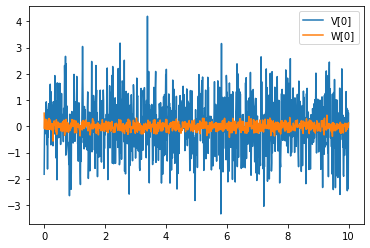

In [16]:
# Create the time vector for the simulation
Tf = 10
T = np.linspace(0, Tf, 1000)

# Create representative process disturbance and sensor noise vectors
np.random.seed(117)           # avoid figures changing from run to run
V = ct.white_noise(T, Qv) # smaller disturbances and noise then design
W = ct.white_noise(T, Qw)
plt.plot(T, V[0], label="V[0]")
plt.plot(T, W[0], label="W[0]")
plt.legend();

### LQR with EKF

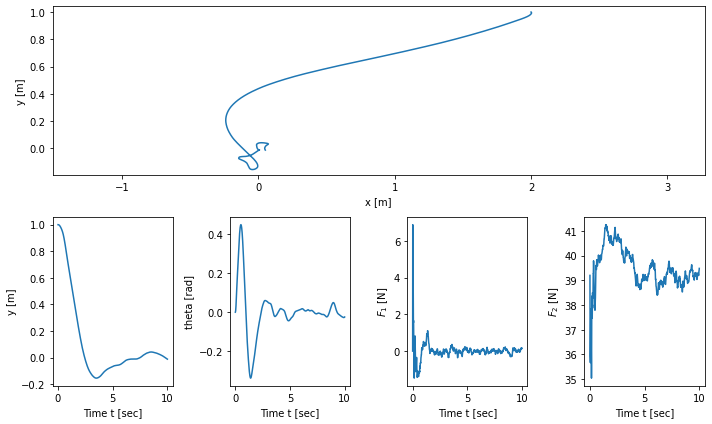

In [17]:
# Put together the input for the system
U = np.vstack([
    np.outer(xe, np.ones_like(T)),      # xd
    np.outer(ue, np.ones_like(T)),      # ud
    V, W                                # disturbances and noise
])
X0 = np.hstack([x0, np.zeros(pvtol.nstates), P0.reshape(-1)])

# Initial condition response
resp = ct.input_output_response(clsys, T, U, X0)

# Plot the response
plot_results(T, resp.states, resp.outputs[pvtol.nstates:])

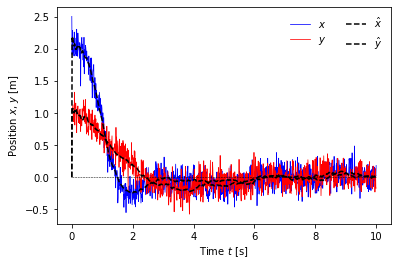

In [18]:
# Response of the first two states, including internal estimates
plt.figure()
h1, = plt.plot(resp.time, resp.outputs[0], 'b-', linewidth=0.75)
h2, = plt.plot(resp.time, resp.outputs[1], 'r-', linewidth=0.75)

# Add on the internal estimator states
xh0 = clsys.find_output('xh0')
xh1 = clsys.find_output('xh1')
h3, = plt.plot(resp.time, resp.outputs[xh0], 'k--')
h4, = plt.plot(resp.time, resp.outputs[xh1], 'k--')

plt.plot([0, 10], [0, 0], 'k--', linewidth=0.5)
plt.ylabel("Position $x$, $y$ [m]")
plt.xlabel("Time $t$ [s]")
plt.legend(
    [h1, h2, h3, h4], ['$x$', '$y$', '$\hat{x}$', '$\hat{y}$'], 
    loc='upper right', frameon=False, ncol=2)

### Full state feedback

As a comparison, we can investigate the response of the system if the exact state was available:

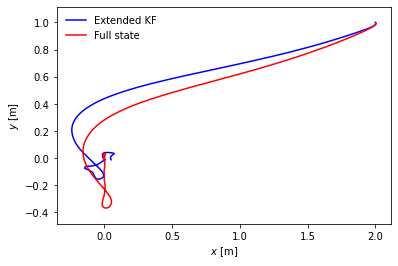

In [19]:
# Compute the full state feedback solution
lqr_ctrl, _ = ct.create_statefbk_iosystem(pvtol, K)

lqr_clsys = ct.interconnect(
    [noisy_pvtol, lqr_ctrl],
    inplist = lqr_ctrl.input_labels[0:pvtol.ninputs + pvtol.nstates] + \
        noisy_pvtol.input_labels[pvtol.ninputs:],
    inputs = lqr_ctrl.input_labels[0:pvtol.ninputs + pvtol.nstates] + \
        noisy_pvtol.input_labels[pvtol.ninputs:],
    outlist = pvtol.output_labels + lqr_ctrl.output_labels,
    outputs = pvtol.output_labels + lqr_ctrl.output_labels
)

# Put together the input for the system
U = np.vstack([
    np.outer(xe, np.ones_like(T)),      # xd
    np.outer(ue, np.ones_like(T)),      # ud
    V, W * 0                            # disturbances and noise
])

# Run a simulation with full state feedback
lqr_resp = ct.input_output_response(lqr_clsys, T, U, x0)

# Compare the results
plt.plot(resp.states[0], resp.states[1], 'b-', label="Extended KF")
plt.plot(lqr_resp.states[0], lqr_resp.states[1], 'r-', label="Full state")

plt.xlabel('$x$ [m]')
plt.ylabel('$y$ [m]')
plt.axis('equal')
plt.legend(frameon=False);